In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

In [3]:
from GreedyInfoMax.vision.models import FullModel, load_vision_model
from GreedyInfoMax.vision.data import get_dataloader

In [4]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [5]:
# Read trained models
folder = 'logs/Fri Feb  7 16:31:38 2020/'
data_input_dir = '/mnt/data/tumor'
model_num = 18

In [6]:
df_test = pd.read_csv(f'{folder}/test_patches.csv')

In [50]:
df_test[(df_test.request_id != df_test.slide_id) & (df_test['Unnamed: 0.1.1'] == 7)]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,seriesInstanceUid,label,request_id,slide_id,block,stain,resolution,...,position_y,filename,center,label_int,app_magnification,app_patch_size,app_version,rater,result_id,row_version
4991,4803,7,7,10104.0,roi_lgl_norm,AIDA-CR1-A-000001,10104.0,K,HE;11,0.4944,...,0.043848,colon_imagedata/roi_lgl_norm/7.jpg,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
df_inference = pd.read_csv('/mnt/data/tumor/inference_result_model_0_dataset_0.csv')

In [131]:
df_inference_sub = df_inference[df_inference.index.isin(df_test[df_test.request_id != df_test.slide_id]['Unnamed: 0.1.1'])]

In [132]:
df_test_w_inference = df_test[(df_test.request_id != df_test.slide_id) & (df_test['Unnamed: 0.1.1'].isin(df_inference.index))]

In [135]:
df_test_w_inference.to_csv(f'{folder}/test_patches_w_inference.csv')

In [134]:
# df_test_sub1 = df_test[df_test.label == 'NONTUMOR'].sample(2000)
# df_test_sub2 = df_test[df_test.label == 'TUMOR'].sample(2000)
# df_test_sub3 = df_test[df_test.label == 'roi_lgl_norm'].sample(2000)
# df_test_sub4 = df_test[df_test.label == 'tumor'].sample(2000)
# df_test_sub = pd.concat([df_test_sub1, df_test_sub2, df_test_sub3, df_test_sub4])

In [136]:
# df_test_sub.to_csv(f'{folder}/test_patches_subset.csv')
df_test_sub = pd.read_csv(f'{folder}/test_patches_w_inference.csv')

In [137]:
class Opt(object):
    pass
opt = Opt()
opt.negative_samples = 12
opt.model_splits = 3
opt.loss = 0
opt.resnet = 50
opt.grayscale = False
opt.prediction_step = 5
opt.train_module = 3
opt.weight_init = False
opt.learning_rate = 2e-4
opt.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt.batch_size = 5
opt.model_type = 0
opt.model_path = folder
opt.model_num = model_num
opt.experiment = 'vision'
opt.data_input_dir = data_input_dir
opt.batch_size_multiGPU = 1
opt.validate = False
opt.dataset = 'cam17'
opt.data_output_dir = folder
opt.training_data_csv = f'{folder}/training_patches.csv'
opt.test_data_csv = f'{folder}/test_patches_w_inference.csv'

In [64]:
model, optimizer = load_vision_model.load_model_and_optimizer(opt, reload_model=True, calc_loss=False)

Contrasting against  12  negative samples
ModuleList(
  (0): ModuleList(
    (0): ResNet_Encoder(
      (model): Sequential(
        (Conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (layer 0): Sequential(
          (0): PreActBottleneckNoBN(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            (shortcut): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (1): PreActBottleneckNoBN(
            (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): PreActBottleneckNoBN(
            (conv1): Conv2d(256, 64, kernel_si

In [138]:
_,_, train_loader,_,test_loader,test_dataset = get_dataloader.get_dataloader(opt)

reading csv file:  logs/Fri Feb  7 16:31:38 2020//training_patches.csv


/home/rxaidacore/.local/share/virtualenvs/Greedy_InfoMax-d3H5Ifm5/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: DtypeWarning: Columns (4,5,6,11,12,13,14,15,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


reading csv file:  logs/Fri Feb  7 16:31:38 2020//test_patches_w_inference.csv
training patches:  label
NONTUMOR         82535
TUMOR            50117
roi_lgl_norm    104467
tumor            83819
dtype: int64
validation patches:  label
roi_lgl_norm    686
tumor            92
dtype: int64
Use (train+val) / test split
Saving training/test set to file


## Run inference on test dataset

In [139]:
model.eval()
total_step = len(test_loader)

outputs = []
labels = []

avg_pool = nn.AvgPool2d((7, 7), stride=0, padding=0)
for step, (img, label) in enumerate(test_loader):
    print('\r {}/{}'.format(step, total_step), end="")
    model_input = img.to(opt.device)
    label = label.to(opt.device)

    _, _, h, _ = model(model_input, label, n=opt.train_module)
    output = avg_pool(h).squeeze().detach().cpu().numpy()
    outputs.append(output)
    labels.append(label.detach().cpu().numpy())



 777/778

In [140]:
# Create dataframe

In [141]:
#df_test = pd.read_csv(f'training_patches.csv')

In [142]:
df_test_sub.groupby('label').size()

label
roi_lgl_norm    686
tumor            92
dtype: int64

In [143]:
len(df_test_sub)

778

In [144]:
out_array = np.stack(outputs, axis=0)

In [145]:
# out_array = np.stack(outputs).reshape((len(outputs)*opt.batch_size, 1024))

In [146]:
out_array.shape

(778, 1024)

In [29]:
# df_test_sub['outputs'] = outputs

In [31]:
slide_df = pd.read_csv('/mnt/data/tumor/slide_mapping_to_center.csv')
def add_center(slide_id):
    center = slide_df[slide_df.slide_id == slide_id].center
    if len(center) < 1:
        return 'colon'
    return str(list(center)[0])

In [32]:
df_test_sub['center'] = df_test_sub.slide_id.apply(add_center)

In [33]:
df_test_sub.center

0         1.0
1         4.0
2         1.0
3         3.0
4         4.0
        ...  
7995    colon
7996    colon
7997    colon
7998    colon
7999    colon
Name: center, Length: 8000, dtype: object

## Visualize with UMAP

In [147]:
reducer = umap.UMAP()

In [148]:
embedding = reducer.fit_transform(out_array)
embedding.shape

(778, 2)

In [149]:
# plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in labels_array])
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the Camleyon + Colon dataset', fontsize=24);

In [150]:
df_test_sub['x'] = embedding[:, 0]
df_test_sub['y'] = embedding[:, 1]

In [151]:
df_test_sub = df_test_sub.drop(['Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0'], axis=1)

In [156]:
df_test_sub = df_test_sub.rename(columns={'Unnamed: 0.1.1.1': 'id'})
df_inference_sub = df_inference_sub.rename(columns={'Unnamed: 0': 'id'})

In [153]:
df_inference_sub.probabilities

7            [9.995639e-01 4.361198e-04]
49           [9.994006e-01 5.993990e-04]
67         [5.1276200e-04 9.9948716e-01]
91         [1.6781878e-06 9.9999833e-01]
141      [1.15264626e-07 9.99999881e-01]
                      ...               
18273      [9.9999416e-01 5.8333330e-06]
18297      [1.0257663e-08 1.0000000e+00]
18309      [1.3702864e-07 9.9999988e-01]
18332      [9.9767494e-05 9.9990022e-01]
18336      [1.0000000e+00 6.1331643e-12]
Name: probabilities, Length: 778, dtype: object

In [157]:
def get_prediction(id):
    pred = list(df_inference_sub[df_inference_sub.id == id].probabilities)[0]
    pred = pred.strip("[]").split()
    pred_float = [float(p) for p in pred]
    max_pred = np.array(pred_float).max()
    return max_pred

In [158]:
df_test_sub['logit'] = df_test_sub.id.apply(get_prediction)

In [159]:
df_test_sub.logit.describe()

count    778.000000
mean       0.982594
std        0.052677
min        0.532872
25%        0.996528
50%        0.999971
75%        1.000000
max        1.000000
Name: logit, dtype: float64

In [37]:
def get_dataset(label):
    if label == 'NONTUMOR': return 'breast'
    if label == 'TUMOR': return 'breast'
    if label == 'roi_lgl_norm': return 'colon'
    if label == 'tumor': return 'colon'

In [38]:
df_test_sub['dataset'] = df_test_sub.label.apply(get_dataset)

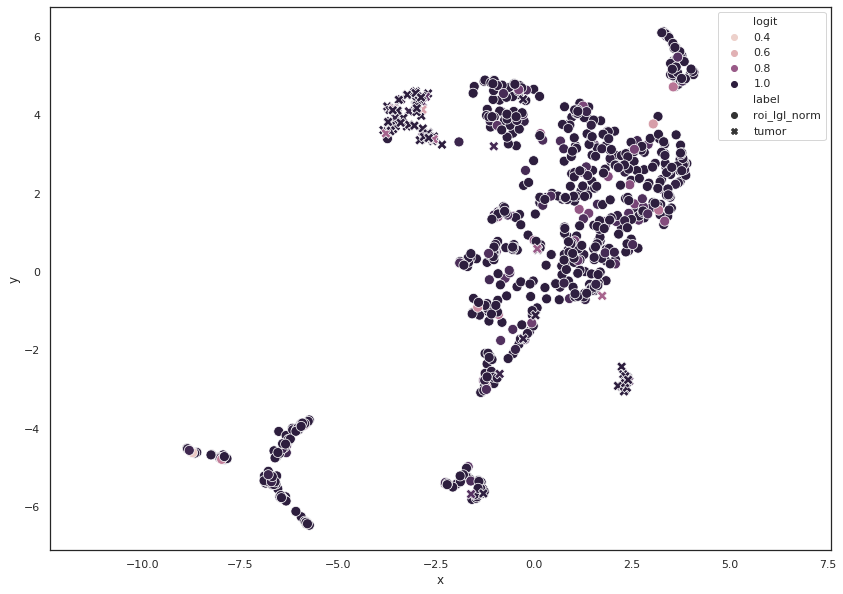

In [160]:
# sns.scatterplot(x='x', y='y', hue='logit', style='label', data=df_test_sub[df_test_sub.dataset == 'breast'])#, palette=sns.color_palette("Blues", 5), s=100, legend=None)
sns.scatterplot(x='x', y='y', hue='logit', style='label', data=df_test_sub, s=100)#, palette=sns.color_palette("Greens", 2), s=100)#, legend=None)
g = plt.gca().set_aspect('equal', 'datalim')

In [408]:
images = []
for idx, row in df_test_sub.iterrows():
    path = f'/mnt/data/tumor/{row.filename}'
    img = np.asarray(Image.open(path).resize((32, 32)))   
    images.append({"img": img, "label": row.label})

In [409]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import ConvexHull
# Plot with images

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1, save=False):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []

    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i['img'], zoom=image_zoom)
        ab = AnnotationBbox(img, 
                            (x0, y0), 
                            xycoords='data', 
                            frameon=False, 
#                             pad=0.2,
#                             bboxprops=dict(edgecolor=tab10_cmap[i['label']], linewidth=3)
                           )
        artists.append(ax.add_artist(ab))
 
    
    alpha = 0.1
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    if save:
        plt.savefig(f'./tsne_img.jpg', format='jpg', dpi=600)
    plt.show()


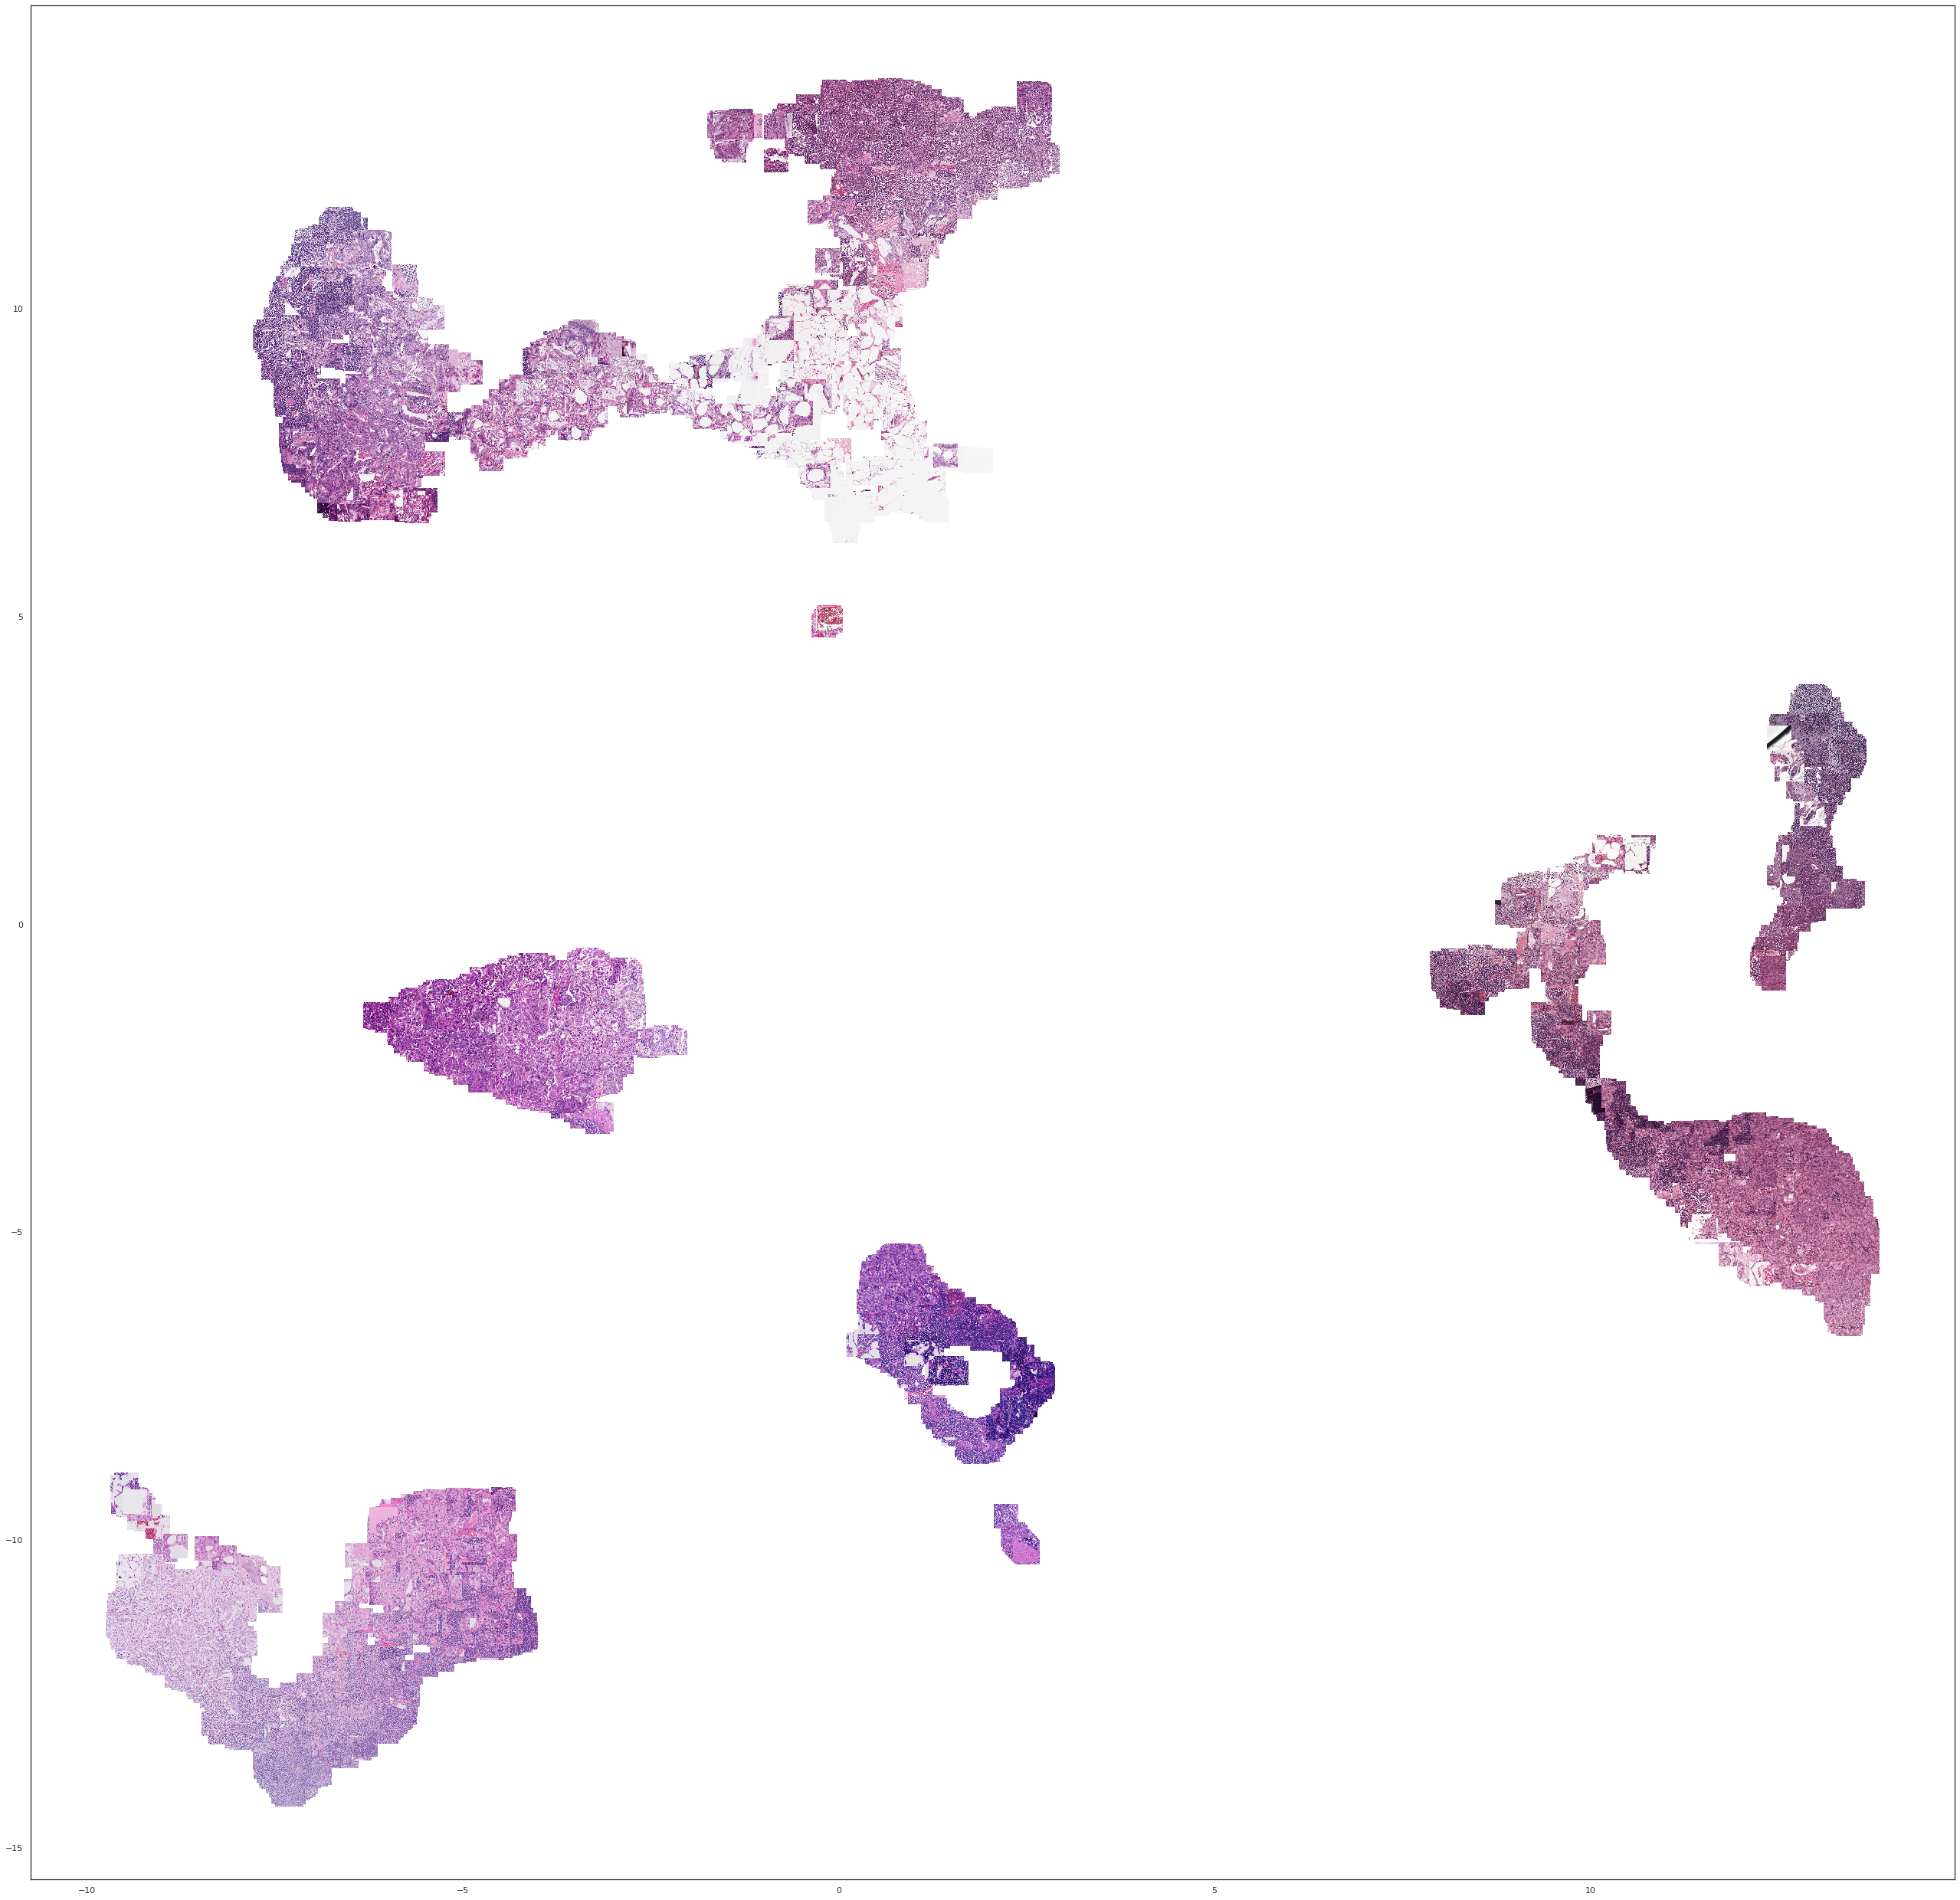

In [410]:
visualize_scatter_with_images(embedding, images, save=False)

## DBSCAN clustering

In [ ]:
from sklearn.cluster import DBSCAN

In [189]:
db = DBSCAN(eps=0.8, min_samples=20).fit(out_array)

In [190]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [191]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Number of clusters: ", n_clusters_)
print("Noise: ", n_noise_)


Number of clusters:  16
Noise:  1653


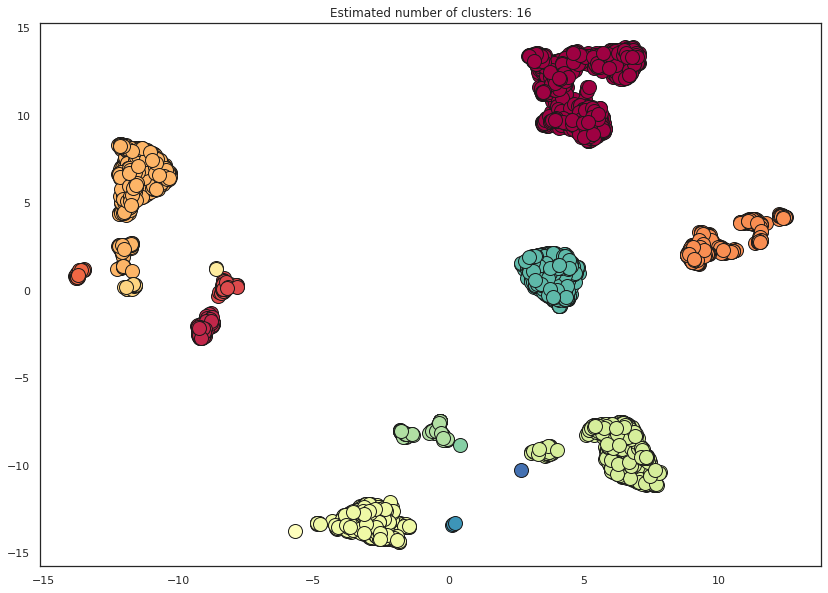

In [194]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embedding[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

#     xy = embedding[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## PCA 

In [208]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(out_array)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.26295346 0.17091656 0.11134203 0.0825031  0.064493   0.06025608
 0.03558998 0.02329587 0.02029815 0.01907042 0.0139443  0.01127549
 0.00975291 0.00940169 0.00816174 0.00659422 0.00567141 0.00549547
 0.00496489 0.00448547 0.00404344 0.00355819 0.00341721 0.00298995
 0.00286513 0.00247451 0.00208914 0.00193463 0.00178082 0.00171446]
[103.898254  83.76466   67.60804   58.197445  51.454704  49.735817
  38.223694  30.924898  28.866692  27.980082  23.92584   21.514765
  20.009485  19.645895  18.304602  16.453201  15.258585  15.02005
  14.276563  13.569784  12.883815  12.086027  11.844162  11.079002
  10.845284  10.078903   9.260876   8.911839   8.550244   8.389442]


In [227]:
out_array_pca30 = pca.transform(out_array)

In [209]:
np.sum(pca.explained_variance_ratio_)

0.9573337

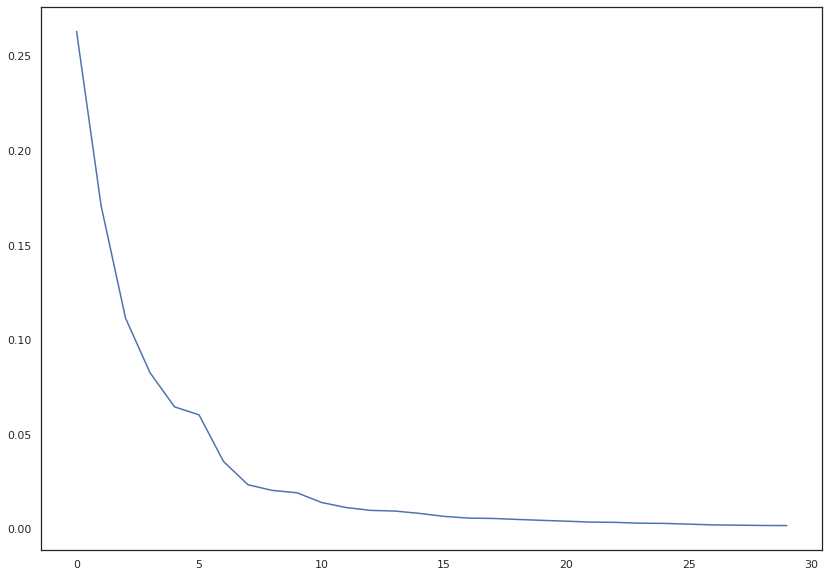

In [210]:
plt.plot(pca.explained_variance_ratio_)

In [225]:
from sklearn.feature_selection import mutual_info_regression

# # reshape necessary because the function accepts many
# # features at once to be compared with the right-hand side
print(mutual_info_regression(out_array[:,0:10], out_array[:,0]))
# print(mutual_info_regression(x.reshape(-1, 1), z))

[7.73058748 0.13418169 0.06951227 0.15269256 0.12299205 0.03885957
 0.29801374 0.05705664 0.11109885 0.25017872]


In [236]:
mutial_info = []
for i in range(30):
    mutial_info.append(mutual_info_regression(out_array_pca30, out_array_pca30[:,i]))

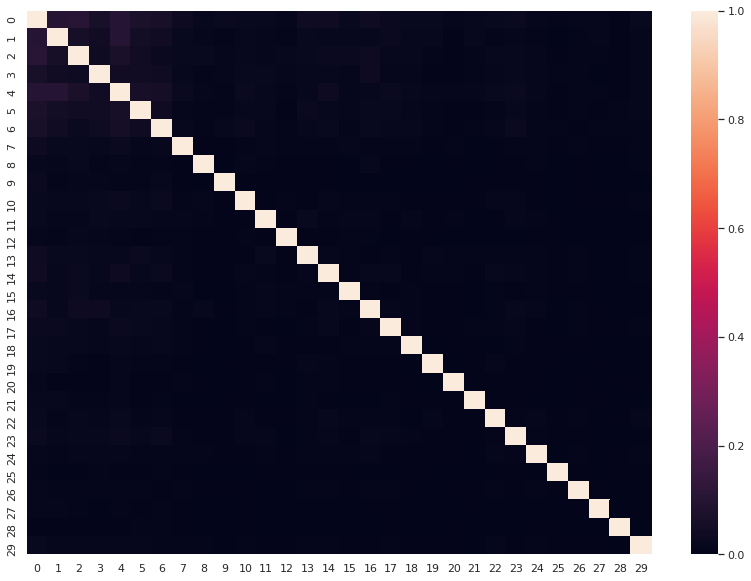

In [241]:
mutial_info = np.stack(mutial_info)
mutial_info = (mutial_info - mutial_info.min())/(mutial_info.max()-mutial_info.min())
sns.heatmap(mutial_info)

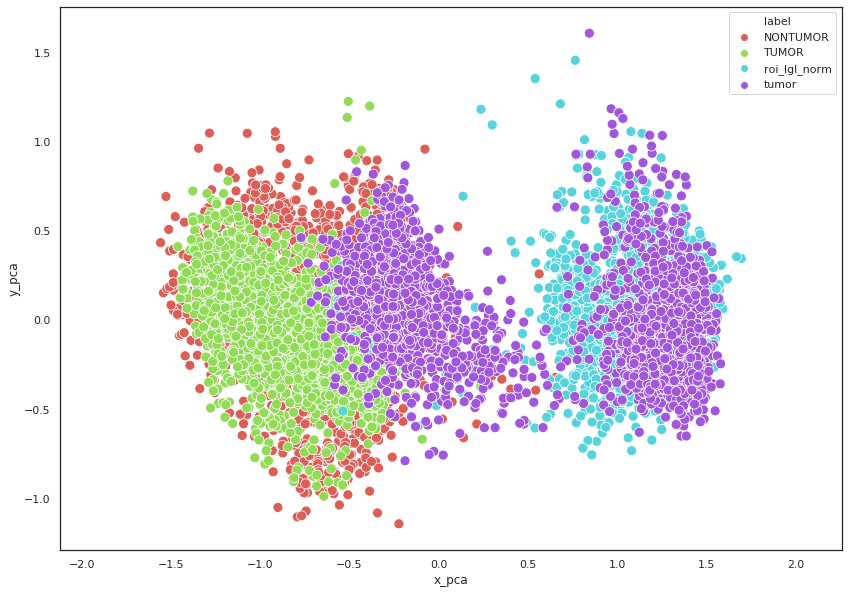

In [289]:
df_tmp = df_test_sub.copy()
df_tmp['x_pca'] = out_array_pca30[:, 1]
df_tmp['y_pca'] = out_array_pca30[:, 8]

sns.scatterplot(x='x_pca', y='y_pca', hue='label', data=df_tmp, palette=sns.color_palette("hls", 4), s=100)#, legend=None)
g = plt.gca().set_aspect('equal', 'datalim')


In [301]:
embedding_pca30 = reducer.fit_transform(out_array_pca30[:, [7,8,9,10,11,12,13,14,15,16,17,18,19,20]])
embedding_pca30.shape

/home/rxaidacore/.local/share/virtualenvs/Greedy_InfoMax-d3H5Ifm5/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../home/rxaidacore/.local/share/virtualenvs/Greedy_InfoMax-d3H5Ifm5/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


(8000, 2)

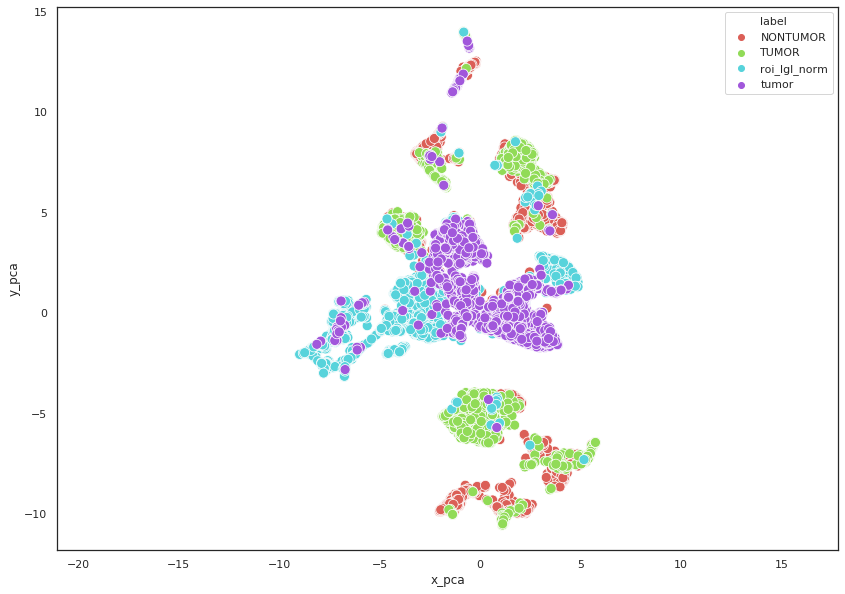

In [302]:
df_tmp = df_test_sub.copy()
df_tmp['x_pca'] = embedding_pca30[:, 0]
df_tmp['y_pca'] = embedding_pca30[:, 1]

sns.scatterplot(x='x_pca', y='y_pca', hue='label', data=df_tmp, palette=sns.color_palette("hls", 4), s=100)#, legend=None)
g = plt.gca().set_aspect('equal', 'datalim')

# Train logistic regression

In [417]:
from GreedyInfoMax.vision.downstream_classification import train_logistic_regression, test_logistic_regression
opt.resnet = 50
opt.num_epochs = 10
#opt.validate = True
opt.batch_size_multiGPU = 128

In [412]:
classification_model = load_vision_model.load_classification_model(opt) # returns linear model with 1024 input and 2 classes output (for cam17)

Sequential(
  (layer1): Linear(in_features=1024, out_features=2, bias=True)
)


In [413]:
optimizer = torch.optim.Adam(classification_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [414]:
model.eval()

DataParallel(
  (module): FullVisionModel(
    (model): ModuleList(
      (0): ModuleList(
        (0): ResNet_Encoder(
          (model): Sequential(
            (Conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (layer 0): Sequential(
              (0): PreActBottleneckNoBN(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
                (shortcut): Sequential(
                  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
                )
              )
              (1): PreActBottleneckNoBN(
                (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
             

In [415]:
# Train logistic regression
try:
    # Train the model
    train_logistic_regression(opt, model, classification_model, train_loader, criterion, optimizer)

except KeyboardInterrupt:
    print("Training got interrupted")

Epoch [1/10], Step [29460/64188], Time (s): 0.4, Acc1: 100.0000, Acc5: 0.0000, Loss: 0.0140Training got interrupted


In [420]:
try:
    acc1, _ , _ = test_logistic_regression(opt, model, classification_model, test_loader, criterion)
    
except KeyboardInterrupt:
    print("Training got interrupted")

Step [1590/1600], Time (s): 0.4, Acc1: 80.0000, Acc5: 0.0000, Loss: 0.27865Testing Accuracy:  78.0125


# Train classifier on data